<h3>Predicting UK rental prices</h3>

Summary: in fitting a regression model to predict the rental prices, I have found the model works well in certain regions but not in other regions. 

It performs best in South West England, in cities like Reading, Bristol, Southampton, where the model R2 is around 80% on the test dataset. It performs worst in London, where R2 is around 35%.

In the Midlands, performance is mixed, while the model works well in Coventry, Leamington Spa and Peterborough (72% R2), it performs poorly for Birmingham, Leicester.

London being such a diverse city with huge price ranges between prime areas and non-prime areas that are often close to each other, the model struggles to capture the factors that matter most in rental prices.

----



<p>Part 1: Getting the current rental listings from Zoopla using Zoopla API, clean the data.</p>
<p>Part 2: EDA</p>
<p>Part 3: Modelling</p>
<p>Part 4: Making rental price prediction using the final model</p>

In [66]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import lib, data, model
import graphs as gr
 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h3>Part 1: Getting the Data</h3>

Cleaning of the data includes:
- delete duplicates
- dealing with missing data
- turn data into binary
- summarise the various types of property into a few category
- exclude commerial properties (parking, shops etc.)
- identify student properties by looking at the description
- identify short term properties and excluding these


In [67]:
# breaking into diff files due to API call limits of 100 per hour ---->
# CV 5262 - FILE 1
# LA 691  | PE 1857 | SK 593 - FILE 2
# CF 3886 | RG 3772 | BS 2074 - FILE 3
# SO 3807 | DN 1310 | EX 1211 | PO 2582 - FILE 4
# LE 2890 |  LS 7000 - FILE 5
# NG 3149 |  YO 753 | BA 1056 - FILE 6
# M1 TO 50 - FILE 7
# Sheffield 2528 | Birmingham 4794 - FILE 8
# Liverpool 3300 ish - File 9

# postcodes = ['liverpool']
# df9 = data.getRegionalData(postcodes,'20200117',9)


In [303]:
# data from API was saved in different files due to API limit, connect the files together into one DF
concatenated_df = data.joinData()

In [304]:
# cleaning the dataset
df = data.cleanData(concatenated_df)
df.shape

(74068, 21)

<h3>Part 2:EDA</h3>

Providing insights to a real estate investor. Here in the EDA I have focused on shared houses / student houses, where it is common to quote rental prices as price per room since a 3 bed house would be rented to 3 sharers rather than one family.

<h4>Question 1: Where should I buy?</h4>

Looking at the average rents for a region or city of interest.

In [305]:
# df.county.value_counts()

In [306]:
region = df

# student or shared houses only ?
region = df[(df['student'] == 1) | (df['shared_occu'] == 1)]

region = region[(region['num_bathrooms'] != 0)]
region = region[(region['num_bedrooms'] <= 10)]


includes = ['Bath & N E Somerset']

def matcher(x):
    for i in includes:
        if x == i:
            return 1
    else:
        return 0

region['include'] = region['county'].apply(matcher)

region = region[region['include']==1]
region.shape

(163, 22)

In [307]:
plt.style.use('bmh')
title = 'Bath Students'

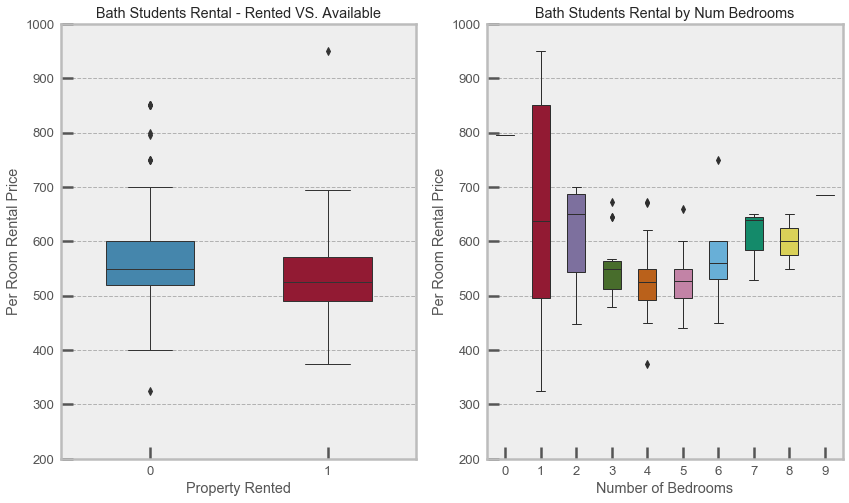

In [308]:
gr.rentPriceGraphs(region,title,'room_pm',200,1_000)

<h4>Question 2: Where type of houses should I buy?</h4>

Looking at the available housing stock in the region, aiming to identify a niche. For example, 2 bed houses or 3 bed houses, on average how many bathrooms do these houses have?

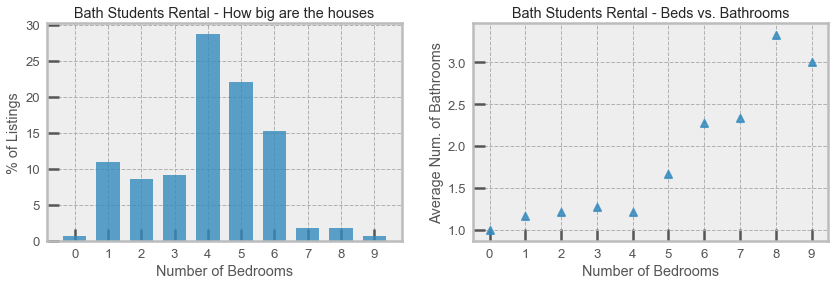

In [311]:
grouped = data.getPerBedroomOvreview(region)

gr.areaOverview(grouped,title)

<h4>Question 3: How much rent difference between houses with less or more bathrooms?</h4>

This is particularly important to shared houses/student houses where tenants would need to share the facilities, with en-suite rooms being more and more popular, I look at how much rent current listings demand for more bathrooms.

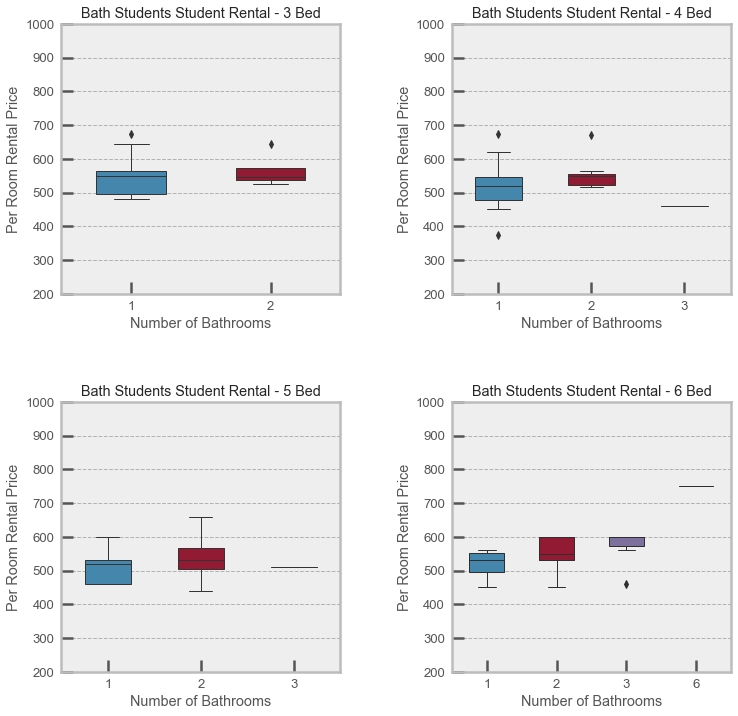

In [312]:
gr.rentPriceBedBath(region,title,'room_pm',200,1000)

In [313]:
# to get a view of what portion of listing have 1, 2, 3 bathrooms etc.
data.getBathroomsByProperSize(region)

,num_bedrooms,num_bathrooms,count,proportion%,rent_pm
0,0,1,1,100.0,795.0
1,1,1,15,83.3,750.0
2,1,2,3,16.7,495.0
3,2,1,11,78.6,648.0
4,2,2,3,21.4,692.0
5,3,1,11,73.3,550.0
6,3,2,4,26.7,545.0
7,4,1,38,80.9,520.0
8,4,2,8,17.0,550.0
9,4,3,1,2.1,460.0


<h4>Part 3: Modelling</h4>

Have tried various models in different stages. First round of modelling is just with the continous variables, then add in the categorical variables, then add in polynomial interactions (2 degree, i.e. up to power of 2) for the continous variables, finally fit using the Lasso model.

I have tried both Lasso and Ridge, but prefer Lasso as in some cases (regions) polynomial interation of power 2 is overfitting the data so Lasso helps to compact this by setting the coef of some predictor variables to zero.

Model assumptions are also checked in the Lasso model by way of visulisations.

In [278]:
# Make sure to fit the model using the right region before prediction in next section

In [314]:
region = df
# note restrictin to students would reduce the data
# region = df[(df['student'] == 1) | (df['shared_occu'] == 1)]

region = region[(region['num_bathrooms'] != 0)]
region = region[(region['num_bedrooms'] <= 10)]

# R2 80% for all, 80% for students
south_west = ['Bristol','Bath & N E Somerset','Wiltshire','North Somerset','Somerset',
           'Hampshire','Southampton','Devon',
           'Berkshire','West Berkshire',
             'Cardiff']

# R2 76% for all, 76% for students
north_west = ['Greater Manchester','Merseyside','Lancashire']

# R2 72% for all, 72% for students - POST_TOWN
midlands = ['Coventry','Leamington Spa','Peterborough']

# R2 63% for all, 42% for students
north_east = ['West Yorkshire','South Yorkshire','North Yorkshire']

def matcher(x):
    for i in includes:
        if x == i:
            return 1
    else:
        return 0

In [315]:
# PUT IN THE REGION HERE ______>>>>>>>>>>

includes = ['Bath & N E Somerset']

region['include'] = region['county'].apply(matcher)
# region['include'] = region['post_twon'].apply(matcher)

region = region[region['include']==1]

print(region.shape)

(424, 22)


Training r^2 %: 84.075
Testing r^2 %: 91.043
Training MSE (mil): 0.12681701380731522
Testing MSE (mil): 0.10857655117132582
----------
Training r^2 %: 89.499
Testing r^2 %: -2.819475262836009e+24
Training MSE (mil): 0.08362766416807432
Testing MSE (mil): 3.417931723332875e+22
----------
Training r^2 %: 90.141
Testing r^2 %: 88.413
Training MSE (mil): 0.07850876717611961
Testing MSE (mil): 0.14046743394170255


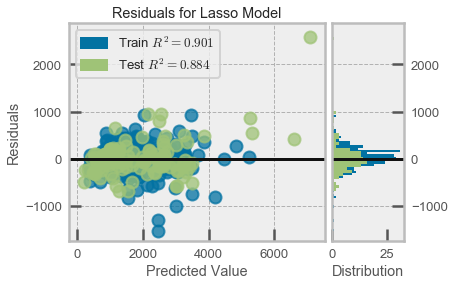

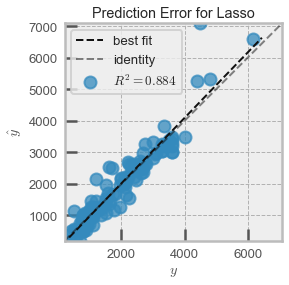

In [316]:

X = region.drop(columns=['rent_price','listing_id','description','details_url',
                         'first_published_date','outcode','room_pm','student','county','post_town','include'])
y = region['rent_price']

run = model.ModelTry(X,y)


## Perform a first naive linear regression model using only Continious Data Variables
lin_con, coef1, X_train, y_train, scaler, poly, ohe = run.run_model(1, False, False)
print("----------")

## add in the categorical variables ---- OVERFITTING with outcode
# lin_reg, coef2, X_train, y_train = run.run_model(2, False, False)
# print("----------")

## add in the polynomial interactions, CHECK effects of overfitting here
lin_poly, coef3, X_train, y_train, scaler, poly, ohe = run.run_model(2, False, True)
print("----------")

## use Lasso model to compact effects of overfitting
las, coef4, X_train, y_train, scaler, poly, ohe = run.run_model(3, True, True)

In [282]:
# look at the top drivers for the model
coef4.sort_values('coef_abs', ascending=False).head(10)


# i.e. more negative longitude means more west

,coef_value,coef_abs
num_bathrooms,895.305826,895.305826
property_type_Detached house,186.638027,186.638027
furnished_state_furnished_or_unfurnished,133.305672,133.305672
property_type_Missing,104.767160,104.767160
property_type_Semi-detached house,-98.916369,98.916369
bills_included furnished_state,-72.032602,72.032602
longitude num_bathrooms,64.877472,64.877472
longitude num_bedrooms,-60.039858,60.039858
latitude longitude,58.475368,58.475368
floor_plan num_bedrooms,-57.106180,57.106180


<h4>Part 4: Predicting rental price with given inputs</h4>

In this section, I use the best model (Lasso) to make prediction of out of sample data points. I.e. given details of a house currently on sale, predict the potential rental price.

In [283]:
# apply same transformation before putting into fitted model

def predict_transform(A):
    # remove "object"-type features and y from `X`
    con_features = [ col for col in A.columns if A[col].dtype in ['int64','float64']]
    A_con = A.loc[:,con_features]


    # Scale the train and test data
    A_sca = scaler.transform(A_con)


    # add in the polynomial interations for the cont. variables
    A_poly = poly.transform(A_sca)
    A_cols = poly.get_feature_names(A.columns)


    # Create X_cat which contains only the categorical variables
    cat_features = [ col for col in A.columns if A[col].dtype == np.object]
    A_cat = A.loc[:,cat_features]


    # OneHotEncode Categorical variables
    A_ohe = ohe.transform(A_cat)

    columns = ohe.get_feature_names(input_features=A_cat.columns)
    cat_df = pd.DataFrame(A_ohe.todense(), columns=columns)

    A_all = pd.concat([pd.DataFrame(A_poly, columns=A_cols), cat_df], axis = 1)

    return A_all


In [299]:
# enter the details of the prediction here ->
A = X.head(1)

# reading house 51.447366, -0.948203
# bath house 51.358789, -2.371651
A.loc[:,'bills_included'] = 0
A.loc[:,'floor_plan'] = 1
A['furnished_state'] = 'furnished'
A['latitude'] = 51.358789
A['longitude'] = -2.371651
A['num_bathrooms'] = 2
A['num_bedrooms'] = 3
A.num_recepts = 1
A.property_type = 'Flats'
A.shared_occu = 1
A.rented = 0

# Try using df.loc[row_index,col_indexer] = value
# A.columns = ['bills_included','floor_plan','furnished_state','latitude','longitude',
#              'num_bathrooms','num_bedrooms','num_recepts','property_type','shared_occu','rented']

In [300]:
X.head(1)

,bills_included,floor_plan,furnished_state,latitude,longitude,num_bathrooms,num_bedrooms,num_recepts,property_type,shared_occu,rented
91701,0.0,1,furnished,51.358789,-2.371651,2,3,1,Flats,1,0


In [301]:
# prediction of monthly rental price ->
A_tr = predict_transform(X.head(1))
las.predict(A_tr)

array([1519.19388056])